# **Blood Cell Images**
Data was taken from Kaggle (https://www.kaggle.com/paultimothymooney/blood-cells).

**Inspiration**

The diagnosis of blood-based diseases often involves identifying and characterizing patient blood samples. Automated methods to detect and classify blood cell subtypes have important medical applications.

**Acknowledgements**

https://github.com/Shenggan/BCCD_Dataset MIT License

**White Blood Cells:**

White blood cells (WBCs) are a part of the immune system that helps fight infection and defend the body against other foreign materials.

Different types of white blood cells are involved in recognizing intruders, killing harmful bacteria, and creating antibodies to protect your body against future exposure to some bacteria and viruses.

These types are distinguished by their physical and functional characteristics.

The five main types: neutrophils, eosinophils, lymphocytes, monocytes and basophils. We will classify the first four types.

## Importing

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import cv2
import h5py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3, InceptionV3
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LSTM, RepeatVector, TimeDistributed, Embedding, BatchNormalization, MaxPool2D
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import models
from tensorflow.keras import layers 

from tensorflow.keras.initializers import Constant

from tqdm import tqdm, tqdm_notebook
from sklearn import preprocessing
from random import sample, choice, seed, shuffle, random, randint

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix

from sklearn.model_selection import KFold, StratifiedKFold

# For image segmentation:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from PIL import Image
%matplotlib inline

Import the data:

In [ ]:
# Mount drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defining main path:
# main_path = '/content/drive/MyDrive/blood_cells_images/dataset2-master/images' # For shiran
main_path= '/content/drive/MyDrive/images' # For sol

In [ ]:
# Defining path for training dataset:
train_images_folder = main_path + '/TRAIN'

In [ ]:
# Defining path for test dataset:
test_images_folder = main_path + '/TEST'

Note: While running the models we checked the images on the test_simple file and noticed that in the 'monocytes' class one image (out of 4) was **mistakenly** classified as 'monocyte'. Hance we've decided to delete all augmented images originated from it and created a new test folder, named: Test repaired. All the results in this notebook refer to that new test folder.

In [ ]:
#New Test folder: test_repaired
test_repaired_images_folder = main_path +'/TEST_REPAIRED'

In [ ]:
# Reading classes names:
classes = os.listdir(train_images_folder)
classes

['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']

Setting general definitions for figures:

In [ ]:
#Title Dict for plot figures:
title_dict = {'fontsize': 14,'fontweight' : 'bold',
 'verticalalignment': 'baseline',
 'horizontalalignment': 'center'}

#Defining label size for figures:
label_size = 14

## Load the data:

In [ ]:
# Trainning data set:
train_images_names = [] # Read all images names to a list
train_images_class = [] # Read each image class 
img_path = [] # List of strings of the images paths
for class_ in classes:
  for line in os.listdir(train_images_folder +'/'+ class_ + '/'):
    img_path.append(train_images_folder +'/'+ class_ + '/')
    train_images_names.append(line.strip())
    train_images_class.append(class_)


In [ ]:
# Test data set:
test_images_names = []
test_images_class = []
img_path_test = []
for class_ in classes:
  for line in os.listdir(test_images_folder +'/'+ class_ + '/'):
    img_path_test.append(test_images_folder +'/'+ class_ + '/')
    test_images_names.append(line.strip())
    test_images_class.append(class_)

In [ ]:
# For Test_repaired data set:
test_r_images_names = []
test_r_images_class = []
img_path_test_r = []
for class_ in classes:
  for line in os.listdir(test_repaired_images_folder +'/'+ class_ + '/'):
    img_path_test_r.append(test_repaired_images_folder +'/'+ class_ + '/')
    test_r_images_names.append(line.strip())
    test_r_images_class.append(class_)

# **The data**

## Visualization of the images:

In [ ]:
# Choose random images every running:
fig_num = [randint(0,2000), randint(3000,4000), randint(5000, 7000), randint(8000, 9500)]

In [ ]:
# "show_image" function - for presenting the image:
def show_image(img_name, label=None):
    img_pat = my_img
    img_obj = plt.imread(img_pat)
    ax = f.add_subplot(1,4,count)
    ax = plt.imshow(img_obj)
    title = f"Size: {img_obj.shape[:2]} , {train_images_class[j]}"
    ax = plt.title(title, fontsize=10)
    plt.axis('off')

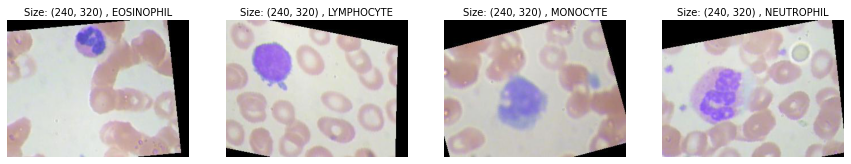

In [ ]:
# Presenting four example images:
f = plt.figure(figsize=(15,30))
count = 1
for j in fig_num:
  my_img = img_path[j] + train_images_names[j]
  show_image(my_img)
  count += 1

## Size of datasets:

Calculate the number of images in each class in each dataset: 

In [ ]:
# Return an array with the number of images from each class 
_, train_counts = np.unique(train_images_class, return_counts = True) # For training dataset
_, test_counts = np.unique(test_r_images_class, return_counts = True) # For test_repaired dataset

Plotting the sizes of datasets:

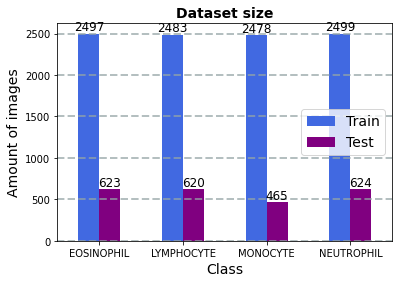

In [ ]:
# Bar plotting:
ax= pd.DataFrame({'Train': train_counts, "Test": test_counts}, index = classes).\
plot.bar(color=['royalblue','purple'])

# Adding the values:
rects= ax.patches
for rect,label_train in zip(rects[:4],train_counts): # For train dataset
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width() / 2, 
          height + 5, 
          label_train,
          ha='center', va='bottom',
          fontsize='large')
for rect,label_test in zip(rects[4:],test_counts): # For test data set
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width() / 2, 
          height + 5, 
          label_test,
          ha='center', va='bottom',
          fontsize='large')

# Some designing...                                                                                                                     
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)  
plt.legend(loc='center right',fontsize=label_size) # Legend
plt.xlabel('Class', fontsize=label_size)
plt.ylabel('Amount of images',fontsize=label_size)
plt.xticks([0,1,2,3], classes, rotation=0)
plt.title('Dataset size', title_dict)
plt.show()

# **Image segmentation**

Credit to the guide of  Rebecca Stone (https://realpython.com/python-opencv-color-spaces/)

By using CV2 we will define the colors of the target cell and mask the surrounding red blood cells

In [ ]:
def hsv_seg1(img,**kwargs):
  
  # Defining the colors range:
  low_color = np.array([115, 40, 0])
  high_color = np.array([150, 180, 255])
  
  # Convert from RGB to BGR:
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  # Smoothing:
  blur = cv2.blur(img,(5,5))
  blur0= cv2.medianBlur(blur,5)
  blur1= cv2.GaussianBlur(blur0,(5,5),0)
  blur2= cv2.bilateralFilter(blur1,9,75,75)
  hsv = cv2.cvtColor(blur2, cv2.COLOR_BGR2HSV)
  # Define mask and result:   
  mask = cv2.inRange(hsv, low_color, high_color)
  res_BGR = cv2.bitwise_and(img,img, mask= mask)
  
  #convert back from BGR to RGB
  res = cv2.cvtColor(res_BGR, cv2.COLOR_BGR2RGB)

  if kwargs.__len__() != 0:
    blur_dict={               # If **kwargs was given, return a dictionary with the two last blur steps.
               'bilateralFilter': blur2,
               'HSV': hsv
               }
    return mask,res, blur_dict
  else:
    return mask, res


In order to understand why we chose these colors, let's check the image RGB:

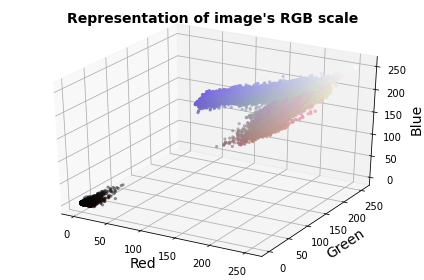

In [ ]:
# Show colored scatter plot of the image in RGB (an example of one image):
my_img2= img_path[10] + train_images_names[10]
image2=cv2.imread(my_img2)
image2= cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

r, g, b = cv2.split(image2)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = image2.reshape((np.shape(image2)[0]*np.shape(image2)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_title("Representation of image's RGB scale", title_dict)
axis.set_xlabel("Red", fontsize= label_size)
axis.set_ylabel("Green", fontsize= label_size)
axis.set_zlabel("Blue", fontsize= label_size, rotation= 90)
plt.tight_layout()
plt.show()

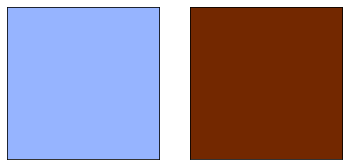

In [ ]:
# Displaying the colors range of the target cell (in RGB):
low_color = np.array([115, 40, 0])
high_color = np.array([150, 180, 255])
lo_square = np.full((10, 10, 3), low_color, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), high_color, dtype=np.uint8) / 255.0

ax1= plt.subplot(1, 2, 1)
plt.imshow(do_square)
ax2= plt.subplot(1, 2, 2)
plt.imshow(lo_square)
# To remove x and y ticks
ax1.tick_params(
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left= False,       # ticks along left edge
    labelbottom=False,  # labels along the bottom (x) edge are off
    labelleft= False)  # labels along the left (y) edge are off
ax2.tick_params(
    axis ='both',
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left= False,       # ticks along left edge
    top=False,         # ticks along the top edge are off
    labelbottom=False,  # labels along the bottom (x) edge are off 
    labelleft= False)  # labels along the left (y) edge are off)  
plt.show()

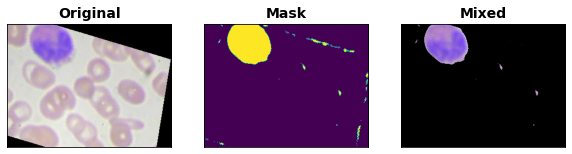

In [ ]:
# An example of the above loop, on one image: 
my_img= img_path[7800] + train_images_names[7800]

my_img = cv2.imread(my_img)

my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2RGB)
mask,res, blur_dict = hsv_seg1(my_img, printfig= 1)

plt.figure(figsize=(10,5))
plt.subplot(1, 3, 1)
plt.imshow(my_img)#  cmap="gray"
plt.title("Original", title_dict)
plt.tick_params(
    axis ='both',
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left= False,       # ticks along left edge
    top=False,         # ticks along the top edge are off
    labelbottom=False,  # labels along the bottom (x) edge are off 
    labelleft= False)  # labels along the left (y) edge are off)  
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.title("Mask", title_dict)
plt.tick_params(
    axis ='both',
    which='both',      
    bottom=False,      
    left= False,       
    top=False,         
    labelbottom=False,  
    labelleft= False)    
plt.subplot(1, 3, 3)
plt.imshow(res)
plt.title("Mixed", title_dict)
plt.tick_params(
    axis ='both',
    which='both',      
    bottom=False,      
    left= False,       
    top=False,         
    labelbottom=False,  
    labelleft= False)  
plt.show()

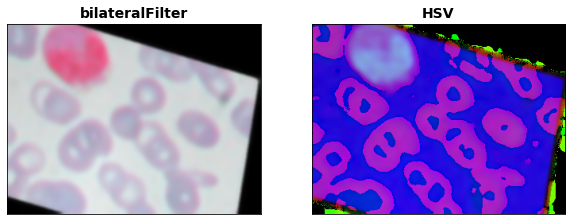

In [ ]:
# Print the two last steps of the smoothing process:
plt.figure(figsize=(10,5))
for i, key in enumerate(blur_dict.keys()):
  plt.subplot(1, len(blur_dict.keys()), i+1)
  plt.imshow(blur_dict[key])
  plt.title(key, title_dict)
  plt.tick_params(
    axis ='both',
    which='both',      
    bottom=False,      
    left= False,       
    top=False,         
    labelbottom=False,  
    labelleft= False) 

**Segmentation Preprocessing:**

Unfortunately we could not use the segmentation function in the image data generator, using preprocess function. Instead we created data sets of the masked images for the train and the test images.

Train:

In [ ]:
# Creating a new data set of masked images:
for i, image in enumerate(train_images_names):
  image_path= img_path[i]+train_images_names[i]
  image_BGR=cv2.imread(image_path) # Read the image
  low_color = np.array([115, 40, 0])
  high_color = np.array([150, 180, 255])
  
  blur = cv2.blur(image_BGR,(5,5))
  blur0=cv2.medianBlur(blur,5)
  blur1= cv2.GaussianBlur(blur0,(5,5),0)
  blur2= cv2.bilateralFilter(blur1,9,75,75)
  hsv = cv2.cvtColor(blur2, cv2.COLOR_BGR2HSV)
  mask = cv2.inRange(hsv, low_color, high_color)
  # Merging the masked and original images:
  result = cv2.bitwise_and(image_BGR, image_BGR, mask=mask) 

  # Saving:
  masked_img_name= image[:-5]+'_newmasked'+image[-5:]
  path= main_path +'/TRAIN_new_MASKED/'+ train_images_class[i]
  
  saving_img=cv2.imwrite(os.path.join(path,masked_img_name), result)

  if saving_img==True:
    print('{} saved successfully'.format(masked_img_name))
    print(train_images_class[i])
  else:
    print('{} had error in saving process'.format(masked_img_name))

Test:

In [ ]:
# Creating a new test dataset of masked images:
for i, image in enumerate(test_r_images_names):
  image_path= img_path_test_r[i]+test_r_images_names[i]
  image_BGR=cv2.imread(image_path) # Read the image
  #image_BGR = ImagePIL.open(image_path)  
  low_color = np.array([115, 40, 0])
  high_color = np.array([150, 180, 255])

  blur = cv2.blur(image_BGR,(5,5))
  blur0=cv2.medianBlur(blur,5)
  blur1= cv2.GaussianBlur(blur0,(5,5),0)
  blur2= cv2.bilateralFilter(blur1,9,75,75)
  hsv = cv2.cvtColor(blur2, cv2.COLOR_BGR2HSV)
  mask = cv2.inRange(hsv, low_color, high_color)

  result = cv2.bitwise_and(image_BGR, image_BGR, mask=mask) # # Merging the masked and original images:

  result_pil = Image.fromarray(result)

  # Saving:
  masked_img_name= image[:-5]+'_newmasked'+image[-5:]
  path= main_path +'/TEST_new_MASKED/'+ test_r_images_class[i]
  #path= 'C:/Users/shiran bahat/Desktop/Data/Blood Cell Images'+ train_images_class[i]+'/'
  saving_img=cv2.imwrite(os.path.join(path,masked_img_name), result)

  #result_pil.save(os.path.join(path,masked_img_name))
  if saving_img==True:
    print('{} saved successfully'.format(masked_img_name))
    print(test_r_images_class[i])
  else:
    print('{} had error in saving process'.format(masked_img_name))

In [ ]:
# Defining new train and test paths for the masked images:
train_masked_folder = main_path + '/TRAIN_new_MASKED'
test_masked_folder = main_path + '/TEST_new_MASKED'

In [ ]:
# Creating list of the classes:
classes_masked= os.listdir(train_masked_folder)
classes_masked

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [ ]:
# Loading masked images
train_masked_images_names=[]
train_masked_images_class= []
masked_img_path=[]
for class_ in classes_masked:
  for line in os.listdir(train_masked_folder +'/'+ class_ + '/'):
    masked_img_path.append(train_masked_folder +'/'+ class_ + '/')
    train_masked_images_names.append(line.strip())
    train_masked_images_class.append(class_)

# **Modeling**

In the following section we will present three main models: ResNet50, Inception V3 and Vgg16. 

Each model has two parts:

1 - Without segmentation (baseline model)

2 - With segmentation

## ResNet50 Model:

Credit to Mehmet -lauda- Tekman (https://www.kaggle.com/mehmetlaudatekman/finetuned-resnet50-83-accuracy)

### Baseline model

**Data generator:**

Using ImageDataGenerator to preprocess the data before modeling
(rescaling of images is done within the model):

In [ ]:
# ImageDataGenerator:
# Add our data-augmentation parameters and spliting to validation set:
trainGen = ImageDataGenerator(validation_split=0.15,
                              vertical_flip=True,
                              horizontal_flip=True,
                              rotation_range=0.2
                             ) # No need to rescale, since we will use ResNet50 

# Note that the test dataset should not be augmented!                             
testGen = ImageDataGenerator()
 
# Flow from directory:
# Flow training images in batches (of 32) using train_datagen generator
trainGenerator = trainGen.flow_from_directory(train_images_folder,
                                              subset="training",
                                              target_size=(224,224),
                                          
                                             )
# Flow validation images in batches (of 32) using train_datagen generator
validationGenerator = trainGen.flow_from_directory(train_images_folder,
                                                   subset="validation",
                                                   target_size=(224,224)
                                                  )

# Flow test images in batches (of 32) using test_datagen generator. Note - Shuffle = False!
test_rGenerator = testGen.flow_from_directory(test_repaired_images_folder,
                                            target_size=(224,224),
                                            shuffle=False                                           
                                           )

Found 8466 images belonging to 4 classes.
Found 1491 images belonging to 4 classes.
Found 2332 images belonging to 4 classes.


**Loading ResNet50 model:**

In [ ]:
base_model_rn = ResNet50(include_top=False,weights="imagenet")  # The base model 
base_model_rn.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
__________________________

In [ ]:
# Use the pre-trained weights up to layer 140:
for layer in base_model_rn.layers[:140]:
    layer.trainable = False 

In [ ]:
print("There are {} layers in model".format(len(base_model.layers)))

There are 175 layers in model


In [ ]:
model_rn = keras.Sequential()  # Initiation of the model

model_rn.add(layers.Input(shape=(224,224,3)))
model_rn.add(layers.Lambda(keras.applications.resnet50.preprocess_input)) # Add preprocess input layer
model_rn.add(base_model_rn) # Add the base model
model_rn.add(layers.GlobalAveragePooling2D()) # Pooling layer to flatten the features
model_rn.add(layers.Dense(4,activation="softmax")) # Output layer with softmax activation

**Running the model:**

Fit

In [ ]:
# Compile:
model_rn.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
# Fit generator:
rn_hist = model_rn.fit_generator(trainGenerator,epochs=5,validation_data=validationGenerator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
265/265 [==============================] - 2407s 9s/step - loss: 0.5053 - accuracy: 0.8115 - val_loss: 0.1652 - val_accuracy: 0.9551
Epoch 2/5
265/265 [==============================] - 125s 470ms/step - loss: 0.0764 - accuracy: 0.9741 - val_loss: 0.1333 - val_accuracy: 0.9571
Epoch 3/5
265/265 [==============================] - 124s 469ms/step - loss: 0.0459 - accuracy: 0.9865 - val_loss: 0.0302 - val_accuracy: 0.9899
Epoch 4/5
265/265 [==============================] - 122s 459ms/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.0605 - val_accuracy: 0.9832
Epoch 5/5
265/265 [==============================] - 116s 437ms/step - loss: 0.0224 - accuracy: 0.9918 - val_loss: 0.1618 - val_accuracy: 0.9463


In [ ]:
# Saving the history of the model:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/rn_history.pkl', 'wb') as f:
     pickle.dump(rn_hist.history, f)

Accuracy and loss as a function of epoch number:

In [ ]:
# Loading history:
# for Shiran:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/rn_history.pkl', 'rb') as f:
    rn_history = pickle.load(f)

# for sol
# with open('/content/drive/MyDrive/images/rn_history.pkl', 'rb') as f:
#     rn_history = pickle.load(f)

In [ ]:
# Credit to kbrans (https://www.kaggle.com/kbrans/vgg16-model-83-36-acc) for 
# "plot_accuracy_loss_chart" function:

def plot_accuracy_loss_chart(history):
    epochs = [i+1 for i in range(len(history['accuracy']))] # Number of epochs in the model
    fig , ax = plt.subplots(2,1)
    # Reading the variables:
    train_acc = history['accuracy']
    train_loss = history['loss']
    val_acc = history['val_accuracy']
    val_loss = history['val_loss']

    fig.set_size_inches(10,9)
    fig.tight_layout(pad=4) # Foe space between the two subplots
    
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy', color= 'blue', alpha=0.7)
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy', color= 'purple', alpha=0.7)
    ax[0].set_title('Training & Validation Accuracy',title_dict)
    ax[0].legend()
    ax[0].set_xticks(list(range(1,len(epochs)+1)))
    ax[0].set_xlabel("Epochs", fontsize=label_size)
    ax[0].set_ylabel("Accuracy",fontsize=label_size)

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss',color= 'blue',alpha=0.7)
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss',color= 'purple', alpha=0.7)
    ax[1].set_title('Training & Validation Loss', title_dict)
    ax[1].legend()
    ax[1].set_xticks(list(range(1,len(epochs)+1)))
    ax[1].set_xlabel("Epochs", fontsize=label_size)
    ax[1].set_ylabel("Training & Validation Loss", fontsize=label_size)
    plt.ion
    plt.show()

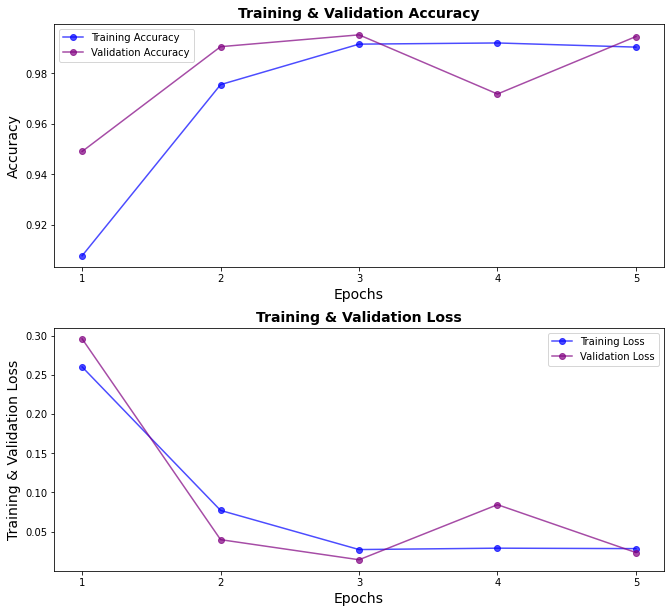

In [ ]:
# Plotting the chart:
plot_accuracy_loss_chart(rn_history)

Predict

In [ ]:
y_pred_rn2 = model_rn.predict_classes(test_rGenerator)
y_true_rn2 = test_rGenerator.labels

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# Display accuracy score:
print("Final test accuracy is {}%".format(accuracy_score(y_pred=y_pred_rn2,y_true=y_true_rn2)))

Final test accuracy is 0.8456260720411664%


**Confusion matrix:**

In [ ]:
# Calculating confusion matrix:
confMatrix = confusion_matrix(y_pred=y_pred_rn2,y_true=y_true_rn2)

In [ ]:
# Saving the confusion matrix:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/rn_confMatrix.pkl', 'wb') as f:
     pickle.dump(confMatrix, f)

In [ ]:
# Loading history:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/rn_confMatrix.pkl', 'rb') as f:
    rn_confMatrix = pickle.load(f)

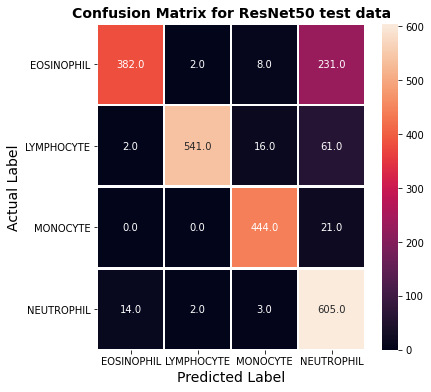

In [ ]:
# Plotting:
plt.subplots(figsize=(6,6))
sns.heatmap(rn_confMatrix,annot=True,fmt=".1f",linewidths=1.5)
plt.xlabel("Predicted Label", fontsize=label_size)
plt.ylabel("Actual Label", fontsize=label_size)
plt.xticks([0.5,1.5,2.5,3.5], ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'])
plt.yticks([0.5,1.5,2.5,3.5], ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], rotation=0)
plt.title('Confusion Matrix for ResNet50 test data', title_dict)
plt.show()

### ResNet 50 with segmentation

**Data generator:**

In [ ]:
# ImageDataGenerator:
trainGen = ImageDataGenerator(validation_split=0.15)

testGen = ImageDataGenerator()
# flow_from_directory:
trainGenerator_seg = trainGen.flow_from_directory(train_masked_folder,
                                              subset="training",
                                              target_size=(224,224),
                                              
                                             )
validationGenerator_seg = trainGen.flow_from_directory(train_masked_folder,
                                                   subset="validation",
                                                   target_size=(224,224)
                                                  )

testGenerator_seg = testGen.flow_from_directory(test_masked_folder,
                                            target_size=(224,224),
                                            shuffle=False
                                                  )


Found 8466 images belonging to 4 classes.
Found 1491 images belonging to 4 classes.
Found 2332 images belonging to 4 classes.


**Loading ResNet50 model:**

In [ ]:
base_model_rn_seg = ResNet50(include_top=False,weights="imagenet")


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# Use the pre-trained weights up to layer 140:
for layer in base_model_rn_seg.layers[:140]:
    layer.trainable = False

In [ ]:
model_rn_seg = keras.Sequential()

model_rn_seg.add(layers.Input(shape=(224,224,3)))
model_rn_seg.add(layers.Lambda(keras.applications.resnet50.preprocess_input))
model_rn_seg.add(base_model_rn_seg)
model_rn_seg.add(layers.GlobalAveragePooling2D())
model_rn_seg.add(layers.Dense(4,activation="softmax"))

**Running the model:**

In [ ]:
# Compile:
model_rn_seg.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

# Fit generator:
rn_seg_hist = model_rn_seg.fit_generator(trainGenerator_seg, epochs=5, validation_data=validationGenerator_seg)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
265/265 [==============================] - 2751s 10s/step - loss: 0.6213 - accuracy: 0.7592 - val_loss: 0.3269 - val_accuracy: 0.8773
Epoch 2/5
265/265 [==============================] - 32s 121ms/step - loss: 0.1761 - accuracy: 0.9245 - val_loss: 0.2278 - val_accuracy: 0.9155
Epoch 3/5
265/265 [==============================] - 32s 122ms/step - loss: 0.1158 - accuracy: 0.9558 - val_loss: 0.2822 - val_accuracy: 0.8994
Epoch 4/5
265/265 [==============================] - 32s 120ms/step - loss: 0.0883 - accuracy: 0.9653 - val_loss: 0.1439 - val_accuracy: 0.9470
Epoch 5/5
265/265 [==============================] - 32s 120ms/step - loss: 0.0613 - accuracy: 0.9772 - val_loss: 0.1935 - val_accuracy: 0.9309


In [ ]:
# Saving history:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/rn_seg_history.pkl', 'wb') as f:
     pickle.dump(rn_seg_hist.history, f)

Accuracy and loss as a function of epoch number:

In [ ]:
# Loading history:
# For Sol:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/rn_seg_history.pkl', 'rb') as f:
  rn_seg_history = pickle.load(f)

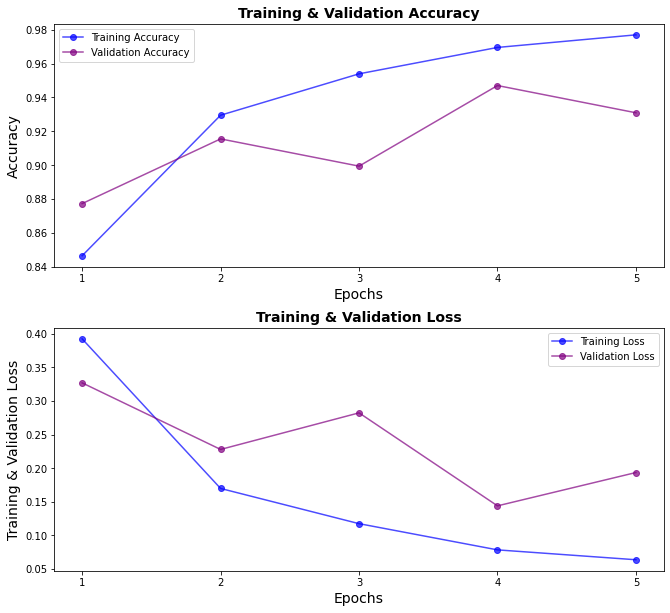

In [ ]:
# Plotting the chart:
plot_accuracy_loss_chart(rn_seg_history)

Predict

In [ ]:
y_pred_rn_seg = model_rn_seg.predict_classes(testGenerator_seg)
y_true_rn_seg = testGenerator_seg.labels

print("Final test accuracy is {}%".format(accuracy_score(y_pred=y_pred_rn_seg,y_true=y_true_rn_seg)))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Final test accuracy is 0.7765866209262435%


**Confusion matrix:**

Final test accuracy is 0.7765866209262435%


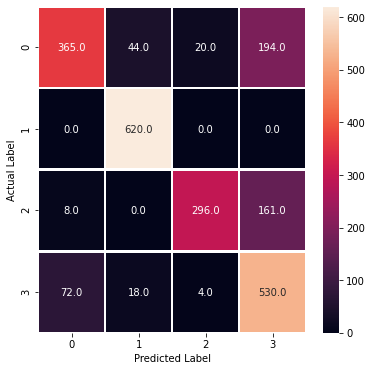

In [ ]:
confMatrix_rn_seg = confusion_matrix(y_pred=y_pred_rn_seg,y_true=y_true_rn_seg)
print("Final test accuracy is {}%".format(accuracy_score(y_pred=y_pred_rn_seg,y_true=y_true_rn_seg)))

plt.subplots(figsize=(6,6))
sns.heatmap(confMatrix_rn_seg,annot=True,fmt=".1f",linewidths=1.5)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

As one could see, in the case of ResNet50 model the segmentation resulted in poorer outcomes in terms of final test accuray (0.77 compared with 0.85 without segmentation). Moreover, the overall correct classifications (i.e., the diagonal of the confusion matrix) had better results without the segmentation. 

## InceptionV3

CNN model we tried to build ourself based on Inception V3 model:

### Baseline model

**Data Generator:**

Using ImageDataGenerator with different augmentation to use for the Inception V3 model:

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(validation_split=0.15, 
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()


In [ ]:
# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_images_folder,
                                                    subset='training' ,
                                                    batch_size = 32, 
                                                    color_mode='rgb', 
                                                    class_mode = 'categorical', 
                                                    target_size = (299, 299),
                                                    shuffle=True, 
                                                    seed=123)

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = train_datagen.flow_from_directory(train_images_folder, 
                                                         subset='validation',
                                                         batch_size = 32, 
                                                         color_mode='rgb', 
                                                         class_mode = 'categorical', 
                                                         target_size = (299, 299),
                                                         shuffle=True, 
                                                         seed=123)

Found 8466 images belonging to 4 classes.
Found 1491 images belonging to 4 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(test_images_folder ,batch_size = 32, color_mode='rgb', class_mode = 'categorical', target_size = (150, 150), shuffle=False)

Found 2487 images belonging to 4 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(test_repaired_images_folder ,batch_size = 32, color_mode='rgb', class_mode = 'categorical', target_size = (299, 299), shuffle=False)

Found 2332 images belonging to 4 classes.


**Loading Inception V3 model:**

In [ ]:
base_model = InceptionV3(input_shape = (299, 299, 3), include_top = False, weights = 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
print("There are {} layers in model".format(len(base_model.layers)))

There are 311 layers in model


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = keras.Sequential()

model.add(layers.Input(shape=(299,299,3)))
model.add(layers.Lambda(keras.applications.inception_v3.preprocess_input))
model.add(base_model)
model.add(layers.GlobalMaxPooling2D()) #Fllaten the features using Global Max Pooling layer
model.add(layers.Dense(256, activation='relu')) #Add Dense layer
model.add(layers.Dense(4,activation="softmax"))

model.compile(optimizer ='adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 22,328,356
Trainable params: 525,572
Non-trainable params: 21,802,784
_________________________________________________________________


**Running the model:**

Fit

In [ ]:
inc_history = model.fit_generator(train_generator, validation_data = validation_generator, epochs = 10)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
265/265 [==============================] - 4556s 17s/step - loss: 3.1824 - acc: 0.2750 - val_loss: 1.4138 - val_acc: 0.3192
Epoch 2/10
265/265 [==============================] - 185s 697ms/step - loss: 1.4068 - acc: 0.3346 - val_loss: 1.3179 - val_acc: 0.3675
Epoch 3/10
265/265 [==============================] - 184s 695ms/step - loss: 1.2987 - acc: 0.3814 - val_loss: 1.3268 - val_acc: 0.3716
Epoch 4/10
265/265 [==============================] - 186s 702ms/step - loss: 1.2799 - acc: 0.4065 - val_loss: 1.2635 - val_acc: 0.4078
Epoch 5/10
265/265 [==============================] - 186s 702ms/step - loss: 1.2642 - acc: 0.4192 - val_loss: 1.2306 - val_acc: 0.4380
Epoch 6/10
265/265 [==============================] - 185s 698ms/step - loss: 1.2335 - acc: 0.4282 - val_loss: 1.1988 - val_acc: 0.4755
Epoch 7/10
265/265 [==============================] - 185s 696ms/step - loss: 1.2183 - acc: 0.4488 - val_loss: 1.2031 - val_acc: 0.4621
Epoch 8/10
265/265 [=============================

In [ ]:
# Saving the history:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/inc_history.pkl', 'wb') as f:
     pickle.dump(inc_history.history, f)

In [ ]:
## Loading the history:
## For Shiran:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/inc_history.pkl', 'rb') as f:
   inc_history = pickle.load(f)

 # # For Sol:
# with open('/content/drive/MyDrive/images/inc_history.pkl', 'rb') as f:
#     inc_history = pickle.load(f)

In [ ]:
# Rename the keys, so it will fit with the figure function:
inc_history['accuracy']= inc_history['acc']
inc_history['val_accuracy']= inc_history['val_acc']

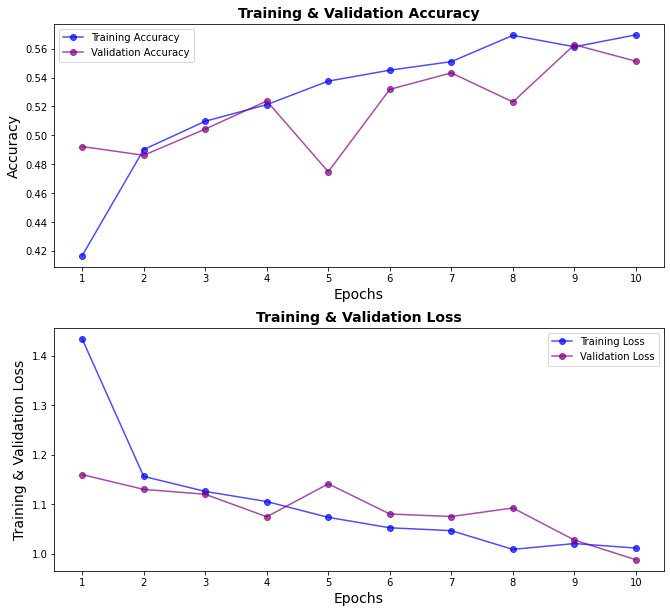

In [ ]:
# Plotting the chart:
plot_accuracy_loss_chart(inc_history)

Predict

In [ ]:
y_pred_inc = model.predict_classes(test_generator)
y_true_inc = test_generator.labels

print("Final test accuracy is {}%".format(accuracy_score(y_pred=y_pred_inc,y_true=y_true_inc)))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Final test accuracy is 0.5613207547169812%


Since the final test accuracy of the baseline model is worse compared with the segmentation model (as will be presented in what follows), we did not display the confusion matrix for that model.

### InceptionV3 with segmentation

**Data generator:**

In [ ]:
# ImageDataGenerator:
train_datagen_seg = ImageDataGenerator(validation_split=0.15, rotation_range = 40,
                                       width_shift_range = 0.2, height_shift_range = 0.2, 
                                       shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen_seg = ImageDataGenerator()

# flow_from_directory:
train_generator_seg = train_datagen_seg.flow_from_directory(train_masked_folder,
                                                            subset='training' ,batch_size = 32, 
                                                            color_mode='rgb', class_mode = 'categorical', 
                                                            target_size = (299, 299),shuffle=True, seed=123)


validation_generator_seg = train_datagen_seg.flow_from_directory(train_masked_folder, 
                                                                 subset='validation'  ,batch_size = 32, 
                                                                 color_mode='rgb', class_mode = 'categorical', 
                                                                 target_size = (299, 299),shuffle=True, seed=123)

test_generator_seg = test_datagen_seg.flow_from_directory(test_masked_folder ,
                                                          batch_size = 32, color_mode='rgb',
                                                          class_mode = 'categorical', 
                                                          target_size = (299, 299), shuffle=False)

Found 8466 images belonging to 4 classes.
Found 1491 images belonging to 4 classes.
Found 2332 images belonging to 4 classes.


**Loading InceptionV3 model:**

In [ ]:
base_model_inc_seg = InceptionV3(input_shape = (299, 299, 3), include_top = False, weights = 'imagenet')

In [ ]:
# Use the pre-trained weigths:
for layer in base_model_inc_seg.layers:
    layer.trainable = False

In [ ]:
model_inc_seg = keras.Sequential()

model_inc_seg.add(layers.Input(shape=(299,299,3)))
model_inc_seg.add(layers.Lambda(keras.applications.inception_v3.preprocess_input))
model_inc_seg.add(base_model_inc_seg)
model_inc_seg.add(layers.GlobalMaxPooling2D())
model_inc_seg.add(layers.Dense(350, activation='relu'))
model_inc_seg.add(layers.Dense(4,activation="softmax"))

**Running the model:**

Fit

In [ ]:
# Compile:
model_inc_seg.compile(optimizer ='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fit generator:
inc_seg_hist = model_inc_seg.fit_generator(train_generator_seg, validation_data = validation_generator_seg, epochs = 10)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
265/265 [==============================] - 203s 747ms/step - loss: 3.1531 - accuracy: 0.5095 - val_loss: 0.7601 - val_accuracy: 0.6975
Epoch 2/10
265/265 [==============================] - 195s 737ms/step - loss: 0.7168 - accuracy: 0.7056 - val_loss: 0.6332 - val_accuracy: 0.7384
Epoch 3/10
265/265 [==============================] - 189s 715ms/step - loss: 0.6117 - accuracy: 0.7470 - val_loss: 0.5850 - val_accuracy: 0.7505
Epoch 4/10
265/265 [==============================] - 184s 694ms/step - loss: 0.5821 - accuracy: 0.7567 - val_loss: 0.5527 - val_accuracy: 0.7619
Epoch 5/10
265/265 [==============================] - 182s 685ms/step - loss: 0.5475 - accuracy: 0.7732 - val_loss: 0.5140 - val_accuracy: 0.7867
Epoch 6/10
265/265 [==============================] - 199s 751ms/step - loss: 0.5295 - accuracy: 0.7842 - val_loss: 0.6457 - val_accuracy: 0.7230
Epoch 7/10
265/265 [==============================] - 205s 774ms/step - loss: 0.5089 - accuracy: 0.7900 - val_loss: 0.5004 -

In [ ]:
# Saving history:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/inc_seg_history.pkl', 'wb') as f:
     pickle.dump(inc_seg_hist.history, f)

Accuracy and loss as a function of epoch number:

In [ ]:
# # Loading the history:

with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/inc_seg_history.pkl', 'rb') as f:
  inc_seg_history = pickle.load(f)

In [ ]:
# Rename the keys, so it will fit with the figure function:
inc_seg_history['accuracy']= inc_seg_history['acc']
inc_seg_history['val_accuracy']= inc_seg_history['val_acc']

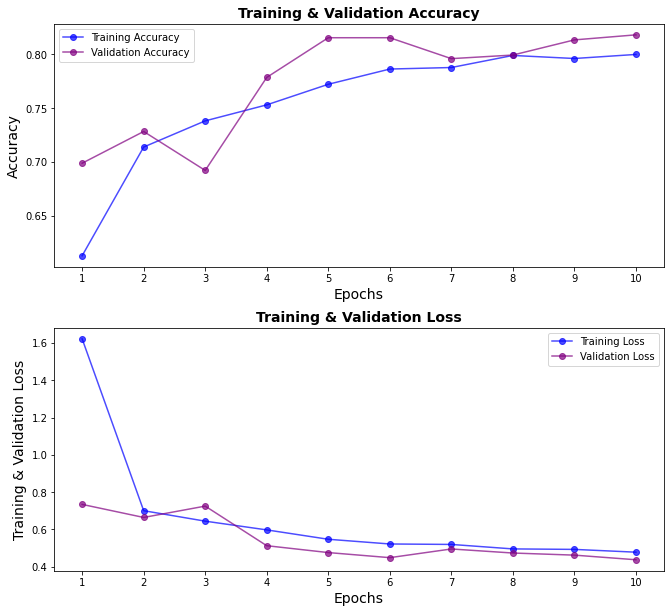

In [ ]:
# Plotting the chart:
plot_accuracy_loss_chart(inc_seg_history)

Predict

In [ ]:
y_pred_inc_seg = model_inc_seg.predict_classes(test_generator_seg)
y_true_inc_seg = test_generator_seg.labels

print("Final test accuracy is {}%".format(accuracy_score(y_pred=y_pred_inc_seg,y_true=y_true_inc_seg)))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Final test accuracy is 0.6410806174957119%


**Confusion matrix:**

In [ ]:
# Calculating the confusion matrix: 
confMatrix_inc_seg = confusion_matrix(y_pred=y_pred_inc_seg,y_true=y_true_inc_seg)

In [ ]:
# Saving:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/confMatrix_inc_seg.pkl', 'wb') as f:
     pickle.dump(confMatrix_inc_seg, f)

In [ ]:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/confMatrix_inc_seg.pkl', 'rb') as f:
  confMatrix_inc_seg = pickle.load(f)

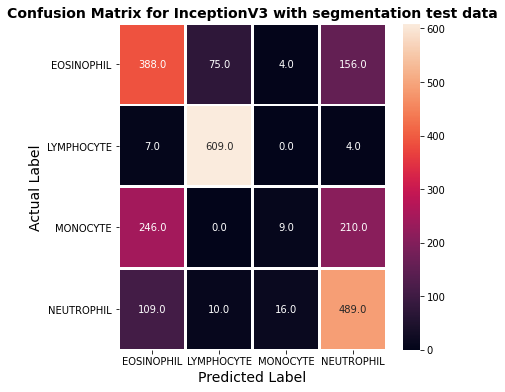

In [ ]:
# Plotting:
plt.subplots(figsize=(6,6))
sns.heatmap(confMatrix_inc_seg,annot=True,fmt=".1f",linewidths=1.5)
plt.xlabel("Predicted Label", fontsize=label_size)
plt.ylabel("Actual Label", fontsize=label_size)
plt.xticks([0.5,1.5,2.5,3.5], ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'])
plt.yticks([0.5,1.5,2.5,3.5], ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], rotation=0)
plt.title('Confusion Matrix for InceptionV3 with segmentation test data', title_dict)
plt.show()

Although the final test accuracy had only a slightly better score with the segmenatation, compared with the baseline model, the model accuracy improved significantly (0.64 compared with 0.56). 

## VGG16 Model

Based on kbrans (https://www.kaggle.com/kbrans/vgg16-model-83-36-acc)

### Baseline model

**Data Generator:**

Using ImageDataGenerator without augmentation for the VGG16 model
(rescaling the images is done within the model, image size = 150,150):

In [ ]:
# ImageDataGenerator:
train_datagen_vgg = ImageDataGenerator(validation_split=0.2)

# flow_from_directory:
train_generator_vgg = train_datagen_vgg.flow_from_directory(
        train_images_folder, subset = 'training',
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32,
        shuffle=True,
        seed=12345,
        class_mode="categorical",
        interpolation= "bilinear") #interpolation bilinear as on cv2.resize. To see if need to change
val_generator_vgg = train_datagen_vgg.flow_from_directory(
        train_images_folder, subset = 'validation',
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32,
        shuffle=True,
        seed=12345,
        class_mode="categorical",
        interpolation= "bilinear")


Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.


In [ ]:
# Test:
test_datagen_vgg = ImageDataGenerator()
test_generator_vgg = test_datagen_vgg.flow_from_directory(
        test_repaired_images_folder,
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32,
        shuffle=False,
        class_mode="categorical",
        interpolation= "bilinear")

Found 2332 images belonging to 4 classes.


**Loading VGG16 model:**

In [ ]:
vgg16_model = VGG16(
    include_top = False,
    weights = 'imagenet', 
    input_tensor = None, 
    input_shape = (150,150,3), 
    pooling = None
)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
# Use the pre-trained weigths:
for layer in vgg16_model.layers:
    layer.trainable = False

In [ ]:
input = Input(shape = (150,150,3))

layer = vgg16_model(inputs=input)
layer = Flatten()(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=256, activation='relu')(layer)
layer = Dropout(0.7)(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=128, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=64, activation='relu')(layer)
layer = Dropout(0.3)(layer)
layer = Dense(units=4,activation='softmax')(layer)

modelvgg16 = Model(inputs=input, outputs=layer)

modelvgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 8192)              32768     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 256)               1024  

In [ ]:
print("There are {} layers in model".format(len(modelvgg16.layers)))

There are 12 layers in model


**Running the model:**

In [ ]:
# Compile:
modelvgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Using reduction rate function for callback:

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

Fit

In [ ]:
# Fit generator:
vgg16_hist = modelvgg16.fit_generator(
    train_generator_vgg,
    epochs = 30, 
    validation_data = val_generator_vgg, verbose=1, callbacks=learning_rate_reduction)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
249/249 [==============================] - 32s 124ms/step - loss: 1.5993 - accuracy: 0.2821 - val_loss: 1.2196 - val_accuracy: 0.5349
Epoch 2/30
249/249 [==============================] - 31s 125ms/step - loss: 1.2747 - accuracy: 0.4121 - val_loss: 0.9063 - val_accuracy: 0.6611
Epoch 3/30
249/249 [==============================] - 30s 122ms/step - loss: 1.0436 - accuracy: 0.5538 - val_loss: 0.7138 - val_accuracy: 0.7270
Epoch 4/30
249/249 [==============================] - 30s 122ms/step - loss: 0.8592 - accuracy: 0.6448 - val_loss: 0.6034 - val_accuracy: 0.7516
Epoch 5/30
249/249 [==============================] - 30s 122ms/step - loss: 0.7468 - accuracy: 0.7032 - val_loss: 0.5621 - val_accuracy: 0.7682
Epoch 6/30
249/249 [==============================] - 30s 122ms/step - loss: 0.6655 - accuracy: 0.7365 - val_loss: 0.5224 - val_accuracy: 0.7979
Epoch 7/30
249/249 [==============================] - 30s 121ms/step - loss: 0.5920 - accuracy: 0.7715 - val_loss: 0.4894 - val_ac

In [ ]:
# Saving the history:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/vgg16_hist.pkl', 'wb') as f:
     pickle.dump(vgg16_hist.history, f)

Accuracy and loss as a function of epoch number:

In [ ]:
# Loading history:
# Shiran:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/vgg16_hist.pkl', 'rb') as f:
  vgg16_history = pickle.load(f)

# # Sol:
# with open('/content/drive/MyDrive/images/vgg16_hist.pkl', 'rb') as f:
#     vgg16_history = pickle.load(f)

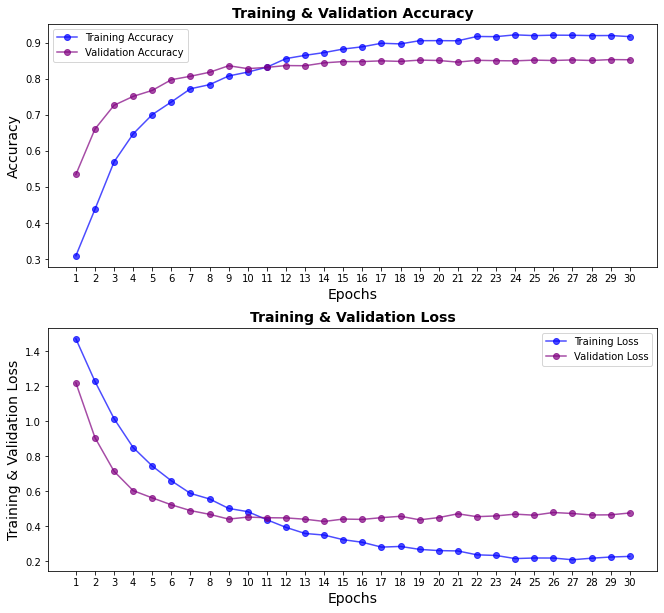

In [ ]:
# Plotting the chart:
plot_accuracy_loss_chart(vgg16_history)

Predict

In [ ]:
y_pred_vgg16 = modelvgg16.predict_generator(test_generator_vgg, verbose=1)
y_true_vgg16 = test_generator_vgg.labels
pred_vgg16 = np.argmax(y_pred_vgg16,axis=1)
print("Final test accuracy is {}%".format(accuracy_score(y_pred=pred_vgg16,y_true=y_true_vgg16)))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


73/73 [==============================] - 7s 97ms/step
Final test accuracy is 0.4403945111492281%


Since the final test accuracy of the baseline model is very low compared with the segmentation (as will be presented in what follows), we did not display the confusion matrix.

### VGG16 with segmentation

**Data Generator:**

Using ImageDataGenerator without augmentation for the VGG16 model (rescaling of images is included in the model, image size = 224,224):

In [ ]:
# ImageDataGenerator:
train_datagen_vgg_seg = ImageDataGenerator(validation_split=0.2)
test_datagen_vgg_seg = ImageDataGenerator()

# flow_from_directory:
train_generator_vgg_seg = train_datagen_vgg_seg.flow_from_directory(
        train_masked_folder, subset = 'training',
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        shuffle=True,
        seed=12345,
        class_mode="categorical",
        interpolation= "bilinear") #interpolation bilinear as on cv2.resize. To see if need to change

val_generator_vgg_seg = train_datagen_vgg_seg.flow_from_directory(
        train_masked_folder, subset = 'validation',
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        shuffle=True,
        seed=12345,
        class_mode="categorical",
        interpolation= "bilinear")

test_generator_vgg_seg = test_datagen_vgg_seg.flow_from_directory(
        test_masked_folder,
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        shuffle=False,
        class_mode="categorical",
        interpolation= "bilinear")

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2332 images belonging to 4 classes.


**Loading VGG16 model:**

In [ ]:
vgg16_seg_model = VGG16(
    include_top = False,
    weights = 'imagenet', 
    input_tensor = None, 
    input_shape = (224,224,3), 
    pooling = None
)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# Use the pre-trained weigths:
for layer in vgg16_seg_model.layers:
    layer.trainable = False

In [ ]:
input = Input(shape = (224,224,3))

layer = vgg16_seg_model(inputs=input)
layer = Flatten()(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=256, activation='relu')(layer)
layer = Dropout(0.7)(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=128, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=64, activation='relu')(layer)
layer = Dropout(0.3)(layer)
layer = Dense(units=4,activation='softmax')(layer)

model_seg_vgg16 = Model(inputs=input, outputs=layer)

model_seg_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization_188 (Bat (None, 25088)             100352    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_189 (Bat (None, 256)               1024  

**Running the model:**

In [ ]:
# Compile:
model_seg_vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Using reduction rate function for callback:

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

Fit

In [ ]:
# Fit generator:
vgg16_seg_hist = model_seg_vgg16.fit_generator(
    train_generator_vgg_seg,
    epochs = 30, 
    validation_data = val_generator_vgg_seg, verbose=1, callbacks=learning_rate_reduction)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
249/249 [==============================] - 45s 174ms/step - loss: 1.5958 - accuracy: 0.2903 - val_loss: 1.1565 - val_accuracy: 0.5571
Epoch 2/30
249/249 [==============================] - 42s 168ms/step - loss: 1.2311 - accuracy: 0.4389 - val_loss: 0.8112 - val_accuracy: 0.6762
Epoch 3/30
249/249 [==============================] - 42s 167ms/step - loss: 0.9781 - accuracy: 0.5623 - val_loss: 0.6276 - val_accuracy: 0.7406
Epoch 4/30
249/249 [==============================] - 41s 164ms/step - loss: 0.8071 - accuracy: 0.6501 - val_loss: 0.5483 - val_accuracy: 0.7597
Epoch 5/30
249/249 [==============================] - 41s 164ms/step - loss: 0.7185 - accuracy: 0.6841 - val_loss: 0.4872 - val_accuracy: 0.7838
Epoch 6/30
249/249 [==============================] - 41s 163ms/step - loss: 0.6430 - accuracy: 0.7109 - val_loss: 0.4466 - val_accuracy: 0.8069
Epoch 7/30
249/249 [==============================] - 42s 167ms/step - loss: 0.5852 - accuracy: 0.7401 - val_loss: 0.4246 - val_ac

In [ ]:
# Saving:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/vgg16_seg_history.pkl', 'wb') as f:
     pickle.dump(vgg16_seg_hist.history, f)

Accuracy and loss as a function of epoch number:

In [ ]:
# # Loading history:
# # For Sol:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/vgg16_seg_history.pkl', 'rb') as f:
  vgg16_seg_history = pickle.load(f)

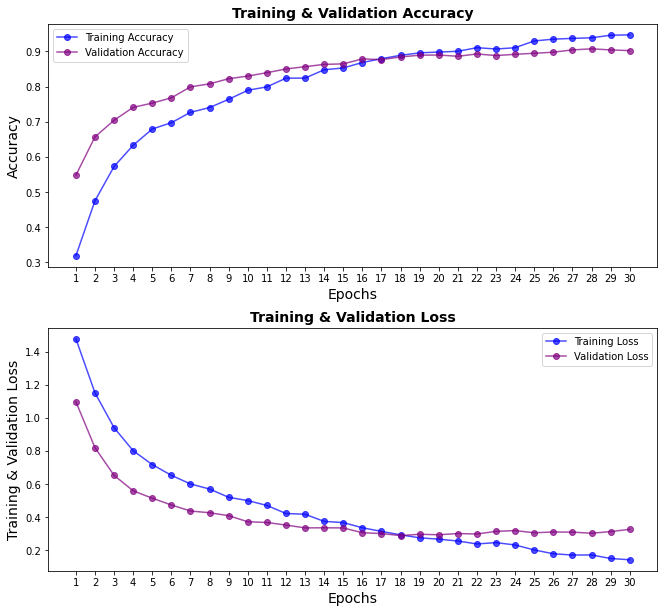

In [ ]:
# Plotting the charts:
plot_accuracy_loss_chart(vgg16_seg_history)

Predict

In [ ]:
y_pred_vgg16_seg = model_seg_vgg16.predict_generator(test_generator_vgg_seg, verbose=1)
y_true_vgg16_seg = test_generator_vgg_seg.labels
pred_vgg16_seg = np.argmax(y_pred_vgg16_seg,axis=1)
print("Final test accuracy is {}%".format(accuracy_score(y_pred=pred_vgg16_seg,y_true=y_true_vgg16_seg)))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


73/73 [==============================] - 10s 137ms/step
Final test accuracy is 0.6509433962264151%


**Confusion matrix:**

In [ ]:
# Calculating the confusion matrix:
confMatrix_vgg_seg = confusion_matrix(y_pred=pred_vgg16_seg,y_true=y_true_vgg16_seg)

In [ ]:
# Saving:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/confMatrix_vgg_seg.pkl', 'wb') as f:
     pickle.dump(confMatrix_vgg_seg, f)


In [ ]:
# # Loading:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/confMatrix_vgg_seg.pkl', 'rb') as f:
  confMatrix_vgg_seg = pickle.load(f)

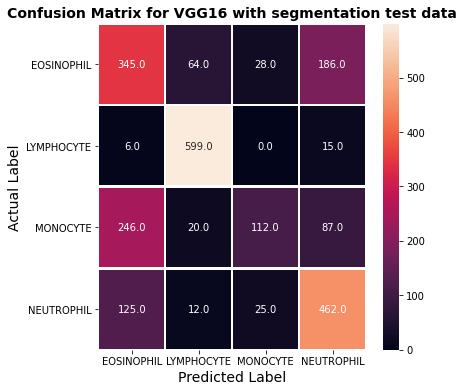

In [ ]:
# Plotting:
plt.subplots(figsize=(6,6))
sns.heatmap(confMatrix_vgg_seg,annot=True,fmt=".1f",linewidths=1.5)
plt.xlabel("Predicted Label", fontsize=label_size)
plt.ylabel("Actual Label", fontsize=label_size)
plt.xticks([0.5,1.5,2.5,3.5], ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'])
plt.yticks([0.5,1.5,2.5,3.5], ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], rotation=0)
plt.title('Confusion Matrix for VGG16 with segmentation test data', title_dict)
plt.show()

# **Comparing the models**

In [ ]:
hist_list=[rn_history,inc_history,vgg16_history,rn_seg_history,inc_seg_history,vgg16_seg_history]
train_acc=[] # List of the last train accuracy of each model
val_acc=[] # List of last validation accuracy of each model
test_acc=[0.85, 0.56,0.44,0.77,0.62,0.63] # The order is by the notebook: all models withput segmentation first

In [ ]:
# Appending the accuracy to lists: 
for model in hist_list:
  train_acc.append(model['accuracy'][-1])
  val_acc.append(model['val_accuracy'][-1])

In [ ]:
# Creating a data frame with all the scores:
acc_df=pd.DataFrame({'Model': ['ResNet50','InceptionV3','VGG16']*6,
                     'Score': train_acc+val_acc+test_acc,
                     'Type': ['Train']*6+['Validation']*6+['Test']*6,
                     'Segmentation': [0,0,0,1,1,1]*3}) # 0- without seg, 1- with seg

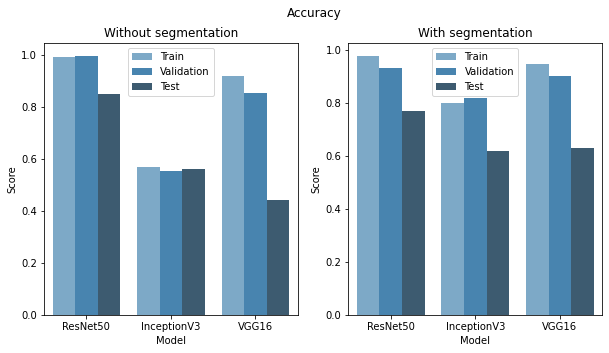

In [ ]:
# Plotting:
fig, (ax1,ax2)= plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Accuracy')
sns.barplot(x=acc_df['Model'][acc_df['Segmentation']==0], y='Score', 
                   hue='Type', data=acc_df,
                   palette="Blues_d",
                   ax=ax1)
ax1.set_title('Without segmentation')
ax1.legend(loc='upper center')

sns.barplot(x=acc_df['Model'][acc_df['Segmentation']==1], y='Score', 
                   hue='Type', data=acc_df,
                   palette="Blues_d",
                   ax=ax2)
ax2.set_title('With segmentation')
ax2.legend(loc='upper center')

plt.show()

To sum up the results we've got so far:

1. As mentioned before, ResNet50 model had higher score without the segmentation, while InceptionV3 and VGG16 did improve their scores using the segmentation preprocess.
2. Overall, it seems like Resnet50 had the best final test score.
3. As one can notice, for all the models the test scores are relatively low compared with the validation scores. The low scores are in accordance with the poor quality of the test dataset (after professional review of the images). Hence, we've decided to run the better version of each one of the three models using cross-validation to assure the validity of the models without the test dataset.

#**Cross validation**

### Preparing the data

In order to use the split method we converted the data into data frame

Without segmentation (for ResNet50 model):

In [ ]:
#Prepering the data to load in the Data Frame:
img_path_list =[]
for i, img in enumerate(img_path):
  temp_name = img + train_images_names[i]
  img_path_list.append(temp_name)

In [ ]:
# Defining the DataFrame:
train_df = pd.DataFrame(list(zip(img_path_list, train_images_class)), columns=['Img', 'Label'])
# Dafining the Y (predicted variable):
Y = train_df[['Label']]

With segmentation (for InceptionV3 and VGG16 models):

In [ ]:
img_seg_path_list =[] # Creating a list of the masked images paths
for i, img in enumerate(masked_img_path):
  temp_name = img + train_masked_images_names[i]
  img_seg_path_list.append(temp_name)

In [ ]:
# Defining the DataFrame:
train_seg_df = pd.DataFrame(list(zip(img_seg_path_list, train_masked_images_class)), columns=['Img', 'Label'])
# Dafining the Y (predicted variable):
Y_seg = train_seg_df[['Label']]

### ResNet50 baseline model

**Loading the model:**

In [ ]:
base_model_rn = ResNet50(include_top=False,weights="imagenet")

for layer in base_model_rn.layers[:140]:
    layer.trainable = False 

**Coding and running the cross validation:**

In [ ]:
# Defining the size of the x-train size:
n=train_df.shape[0]

# A function which creates the name of the model history:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

# Defining a path to save the model results:
save_dir = '/content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/rn_cv' 

#Creating a list to save all validaion accuracy in the end of every run
val_accuracy_list = []

#The Image Data generator for the train, using augmentation:
trainGen = ImageDataGenerator(vertical_flip=True,
                              horizontal_flip=True,
                              rotation_range=0.2)
#The Image Data generator for the validation set, without augmentation
valGen = ImageDataGenerator()

#The CV, using startified K fold:                         
skf = StratifiedKFold(n_splits = 5, random_state = 6767, shuffle = True) 

#Spliting:
i = 1
for train_index, val_index in skf.split(np.zeros(n),Y):
  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
  
  #Using Data generator for train and for validation, from same 'trainig data', 
  # using flow from dataframe method:
  trainGenerator = trainGen.flow_from_dataframe(training_data, directory=train_images_folder,
						       x_col = "Img", y_col = "Label",
						       class_mode = "categorical", shuffle = True, target_size=(224,224))

  validationGenerator = valGen.flow_from_dataframe(validation_data, directory=train_images_folder,
						       x_col = "Img", y_col = "Label",
						       class_mode = "categorical", shuffle = False, target_size=(224,224))
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(i), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint] 

  #Initiating the model in each iteration:
  model_rn = keras.Sequential()  # Initiation of the model

  model_rn.add(layers.Input(shape=(224,224,3)))
  model_rn.add(layers.Lambda(keras.applications.resnet50.preprocess_input)) # Add preprocess input layer
  model_rn.add(base_model_rn) # Add the base model
  model_rn.add(layers.GlobalAveragePooling2D()) # Pooling layer to flatten the features
  model_rn.add(layers.Dense(4,activation="softmax")) 
  # Running the model:
  # Compile:
  model_rn.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
  # Fit: 
  rn_hist_cv = model_rn.fit_generator(trainGenerator,epochs=5,validation_data=validationGenerator, callbacks=callbacks_list)
  
  #Saving each model history:
  with open("/content/drive/MyDrive/blood_cells_images/dataset2-master/rn_cv_hist"+str(i)+".pkl", 'wb') as f:
     pickle.dump(rn_hist_cv.history, f)
  
  #Predict:
  pred = model_rn.predict_classes(validationGenerator)
  oos_y = validationGenerator.labels
  # Accuracy score:
  score = accuracy_score(y_pred=pred,y_true=oos_y)
  val_accuracy_list.append(score)

  #Saving Confusion Matrix for the last run:
  if i == skf.n_splits:
    confMatrix_rn_cv = confusion_matrix(y_pred=pred,y_true=oos_y)
    with open("/content/drive/MyDrive/blood_cells_images/dataset2-master/confMatrix_rn_cv.pkl", 'wb') as f:
      pickle.dump(confMatrix_rn_cv, f)

  i+=1

#Saving the validation accuracy list of all models:
with open("/content/drive/MyDrive/blood_cells_images/dataset2-master/rn_cv_val_acc.pkl", 'wb') as f:
     pickle.dump(val_accuracy_list, f)

Found 7965 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
249/249 [==============================] - 4374s 18s/step - loss: 0.5403 - accuracy: 0.8084 - val_loss: 0.1663 - val_accuracy: 0.9453

Epoch 00001: val_accuracy improved from -inf to 0.94528, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/rn_cvmodel_1.h5
Epoch 2/5
249/249 [==============================] - 96s 384ms/step - loss: 0.0855 - accuracy: 0.9711 - val_loss: 0.0730 - val_accuracy: 0.9769

Epoch 00002: val_accuracy improved from 0.94528 to 0.97691, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/rn_cvmodel_1.h5
Epoch 3/5
249/249 [==============================] - 96s 385ms/step - loss: 0.0378 - accuracy: 0.9886 - val_loss: 0.0352 - val_accuracy: 0.9900

Epoch 00003: val_accuracy improved from 0.97691 to 0.98996, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/rn_cvmodel_1.h5
Epoch 4/5
249/249 [==============================] - 100s 400ms/step - loss: 0.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Found 7965 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
249/249 [==============================] - 101s 394ms/step - loss: 0.1431 - accuracy: 0.9459 - val_loss: 0.0634 - val_accuracy: 0.9819

Epoch 00001: val_accuracy improved from -inf to 0.98193, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/rn_cvmodel_2.h5
Epoch 2/5
249/249 [==============================] - 99s 396ms/step - loss: 0.0333 - accuracy: 0.9894 - val_loss: 0.2573 - val_accuracy: 0.9307

Epoch 00002: val_accuracy did not improve from 0.98193
Epoch 3/5
249/249 [==============================] - 98s 392ms/step - loss: 0.0135 - accuracy: 0.9959 - val_loss: 0.0176 - val_accuracy: 0.9950

Epoch 00003: val_accuracy improved from 0.98193 to 0.99498, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/rn_cvmodel_2.h5
Epoch 4/5
249/249 [==============================] - 98s 392ms/step - loss: 0.0129 - accuracy: 0.9944 - val_loss: 0.0280 - val_accuracy: 0.9915

Epoch 00004: val_accuracy did not improve

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Found 7966 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
249/249 [==============================] - 100s 388ms/step - loss: 0.1051 - accuracy: 0.9722 - val_loss: 0.0466 - val_accuracy: 0.9844

Epoch 00001: val_accuracy improved from -inf to 0.98443, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/rn_cvmodel_3.h5
Epoch 2/5
249/249 [==============================] - 96s 386ms/step - loss: 0.0249 - accuracy: 0.9913 - val_loss: 0.0066 - val_accuracy: 0.9985

Epoch 00002: val_accuracy improved from 0.98443 to 0.99849, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/rn_cvmodel_3.h5
Epoch 3/5
249/249 [==============================] - 96s 385ms/step - loss: 0.0096 - accuracy: 0.9976 - val_loss: 0.0038 - val_accuracy: 0.9990

Epoch 00003: val_accuracy improved from 0.99849 to 0.99900, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/rn_cvmodel_3.h5
Epoch 4/5
249/249 [==============================] - 97s 390ms/step - loss: 0.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Found 7966 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
249/249 [==============================] - 101s 392ms/step - loss: 0.0875 - accuracy: 0.9749 - val_loss: 0.1031 - val_accuracy: 0.9724

Epoch 00001: val_accuracy improved from -inf to 0.97238, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/rn_cvmodel_4.h5
Epoch 2/5
249/249 [==============================] - 97s 388ms/step - loss: 0.0082 - accuracy: 0.9966 - val_loss: 0.0071 - val_accuracy: 0.9975

Epoch 00002: val_accuracy improved from 0.97238 to 0.99749, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/rn_cvmodel_4.h5
Epoch 3/5
249/249 [==============================] - 97s 391ms/step - loss: 0.0204 - accuracy: 0.9944 - val_loss: 0.0141 - val_accuracy: 0.9965

Epoch 00003: val_accuracy did not improve from 0.99749
Epoch 4/5
249/249 [==============================] - 97s 388ms/step - loss: 0.0089 - accuracy: 0.9985 - val_loss: 0.0080 - val_accuracy: 0.9975

Epoch 00004: val_accuracy did not improve

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Found 7966 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
249/249 [==============================] - 101s 392ms/step - loss: 0.0904 - accuracy: 0.9684 - val_loss: 0.0058 - val_accuracy: 0.9985

Epoch 00001: val_accuracy improved from -inf to 0.99849, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/rn_cvmodel_5.h5
Epoch 2/5
249/249 [==============================] - 98s 392ms/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.0014 - val_accuracy: 1.0000

Epoch 00002: val_accuracy improved from 0.99849 to 1.00000, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/rn_cvmodel_5.h5
Epoch 3/5
249/249 [==============================] - 97s 390ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.0010 - val_accuracy: 1.0000

Epoch 00003: val_accuracy did not improve from 1.00000
Epoch 4/5
249/249 [==============================] - 97s 388ms/step - loss: 0.0148 - accuracy: 0.9955 - val_loss: 0.0042 - val_accuracy: 0.9990

Epoch 00004: val_accuracy did not improve

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


**Validation accuracy:**

In [ ]:
# Loading:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/rn_cv_val_acc.pkl', 'rb') as f:
     rn_cv_val_acc = pickle.load(f)

In [ ]:
# Display validation accuracy results:
rn_cv_val_acc

[0.9954819277108434,
 0.9979919678714859,
 0.9979909593169262,
 0.9994977398292315,
 1.0]

**Confusion matrix:**

In [ ]:
# Loading confusion matrix:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/confMatrix_rn_cv.pkl', 'rb') as f:
     confMatrix_rn_cv = pickle.load(f)

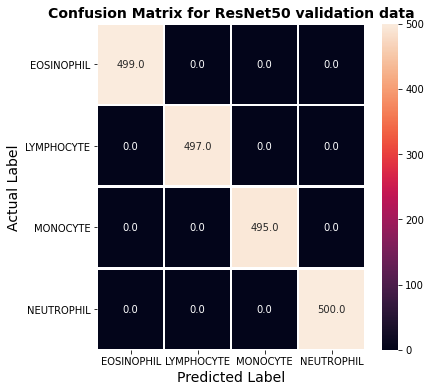

In [ ]:
# Plotting:
plt.subplots(figsize=(6,6))
sns.heatmap(confMatrix_rn_cv,annot=True,fmt=".1f",linewidths=1.5)
plt.xlabel("Predicted Label", fontsize=label_size)
plt.ylabel("Actual Label", fontsize=label_size)
plt.xticks([0.5,1.5,2.5,3.5], ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'])
plt.yticks([0.5,1.5,2.5,3.5], ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], rotation=0)
plt.title('Confusion Matrix for ResNet50 validation data', title_dict)
plt.show()

### InceptionV3 model with segmentation

**Loading the model:**

In [ ]:
base_model_inc_seg = InceptionV3(input_shape = (299, 299, 3), include_top = False, weights = 'imagenet')

for layer in base_model_inc_seg.layers:
    layer.trainable = False 

**Coding and running the cross validation:**

In [ ]:
# Defining the size of the x-train size:
n=train_seg_df.shape[0]

# A function which creates the name of the model history:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

# Defining a path to save the model results:
save_dir = '/content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/inc_cv'

# An empty list for the validation accuracy results (of all n_splits):
inc_val_accuracy_list = []

# ImageDataGenerator:
# For train- with augmentations:
train_datagen_seg = ImageDataGenerator(rotation_range = 40,
                                       width_shift_range = 0.2, height_shift_range = 0.2, 
                                       shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
# For validation- without augmentations:
val_datagen_seg = ImageDataGenerator()

# Defining the StratifiedKFold:                   
skf = StratifiedKFold(n_splits = 5, random_state = 6767, shuffle = True) 

# Splitting the data:
i = 1
for train_index, val_index in skf.split(np.zeros(n),Y_seg):
  training_data = train_seg_df.iloc[train_index]
  validation_data = train_seg_df.iloc[val_index]
 # flow_from_dataframe:
  trainGenerator = train_datagen_seg.flow_from_dataframe(training_data, directory=train_masked_folder,
						       x_col = "Img", y_col = "Label",
						       class_mode = "categorical", shuffle = True, target_size=(299, 299), seed=123)

  validationGenerator = val_datagen_seg.flow_from_dataframe(validation_data, directory=train_masked_folder,
						       x_col = "Img", y_col = "Label",
						       class_mode = "categorical", shuffle = False, target_size=(299, 299))
  # Checkpoint:
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(i), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]    
  
  # Loading the model:
  model_inc_seg = keras.Sequential()
  model_inc_seg.add(layers.Input(shape=(299,299,3)))
  model_inc_seg.add(layers.Lambda(keras.applications.inception_v3.preprocess_input))
  model_inc_seg.add(base_model_inc_seg)
  model_inc_seg.add(layers.GlobalMaxPooling2D())
  model_inc_seg.add(layers.Dense(350, activation='relu'))
  model_inc_seg.add(layers.Dense(4,activation="softmax"))
  
  # Running the model:
  # Compile:
  model_inc_seg.compile(optimizer ='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  # Fit generator:
  inc_seg_hist_cv = model_inc_seg.fit_generator(trainGenerator, validation_data = validationGenerator, epochs = 10, callbacks=callbacks_list)
  
  # Saving the history:
  with open("/content/drive/MyDrive/blood_cells_images/dataset2-master/inc_cv_hist"+str(i)+".pkl", 'wb') as f:
     pickle.dump(inc_seg_hist_cv.history, f)
  
  # Predict validation:
  pred = model_inc_seg.predict_classes(validationGenerator)
  oos_y = validationGenerator.labels
  # Accuracy score:
  score = accuracy_score(y_pred=pred,y_true=oos_y)
  # Append the accuracy score of that iteration to a list:
  inc_val_accuracy_list.append(score)
  
  # Confusion matrix of the last iteration:
  if i == skf.n_splits:
    confMatrix_inc_seg_cv = confusion_matrix(y_pred=pred,y_true=oos_y)
    with open("/content/drive/MyDrive/blood_cells_images/dataset2-master/confMatrix_inc_seg_cv.pkl", 'wb') as f:
      pickle.dump(confMatrix_inc_seg_cv, f)
  i+=1 

# Saving the validation accuracy list:
with open("/content/drive/MyDrive/blood_cells_images/dataset2-master/inc_cv_val_acc.pkl", 'wb') as f:
     pickle.dump(inc_val_accuracy_list, f)


Found 7965 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
249/249 [==============================] - 3829s 15s/step - loss: 3.7879 - accuracy: 0.5106 - val_loss: 0.8799 - val_accuracy: 0.6461

Epoch 00001: val_accuracy improved from -inf to 0.64608, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/inc_cvmodel_1.h5
Epoch 2/10
249/249 [==============================] - 157s 632ms/step - loss: 0.7523 - accuracy: 0.6965 - val_loss: 0.5654 - val_accuracy: 0.7811

Epoch 00002: val_accuracy improved from 0.64608 to 0.78112, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/inc_cvmodel_1.h5
Epoch 3/10
249/249 [==============================] - 152s 610ms/step - loss: 0.6556 - accuracy: 0.7305 - val_loss: 0.5535 - val_accuracy: 0.7726

Epoch 00003: val_accuracy did not improve from 0.78112
Epoch 4/10
249/249 [==============================] - 150s 602ms/step - loss: 0.6282 - accuracy: 0.7442 - val_loss: 0.4609 - val_accuracy: 0.8243

Epoch 00004: val_accuracy improve

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Found 7965 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
249/249 [==============================] - 155s 610ms/step - loss: 3.2127 - accuracy: 0.4980 - val_loss: 0.6792 - val_accuracy: 0.7324

Epoch 00001: val_accuracy improved from -inf to 0.73243, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/inc_cvmodel_2.h5
Epoch 2/10
249/249 [==============================] - 151s 606ms/step - loss: 0.6863 - accuracy: 0.7167 - val_loss: 0.5353 - val_accuracy: 0.7846

Epoch 00002: val_accuracy improved from 0.73243 to 0.78464, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/inc_cvmodel_2.h5
Epoch 3/10
249/249 [==============================] - 151s 606ms/step - loss: 0.6582 - accuracy: 0.7217 - val_loss: 0.5288 - val_accuracy: 0.7826

Epoch 00003: val_accuracy did not improve from 0.78464
Epoch 4/10
249/249 [==============================] - 150s 603ms/step - loss: 0.5507 - accuracy: 0.7769 - val_loss: 0.4630 - val_accuracy: 0.8122

Epoch 00004: val_accuracy improv

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Found 7966 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
249/249 [==============================] - 156s 610ms/step - loss: 3.4602 - accuracy: 0.4997 - val_loss: 0.8448 - val_accuracy: 0.6349

Epoch 00001: val_accuracy improved from -inf to 0.63486, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/inc_cvmodel_3.h5
Epoch 2/10
249/249 [==============================] - 152s 611ms/step - loss: 0.7278 - accuracy: 0.7007 - val_loss: 0.7286 - val_accuracy: 0.7177

Epoch 00002: val_accuracy improved from 0.63486 to 0.71773, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/inc_cvmodel_3.h5
Epoch 3/10
249/249 [==============================] - 151s 606ms/step - loss: 0.6347 - accuracy: 0.7486 - val_loss: 0.5101 - val_accuracy: 0.7966

Epoch 00003: val_accuracy improved from 0.71773 to 0.79658, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/inc_cvmodel_3.h5
Epoch 4/10
249/249 [==============================] - 152s 608ms/step 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Found 7966 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
249/249 [==============================] - 155s 610ms/step - loss: 3.0964 - accuracy: 0.5260 - val_loss: 0.7120 - val_accuracy: 0.7032

Epoch 00001: val_accuracy improved from -inf to 0.70316, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/inc_cvmodel_4.h5
Epoch 2/10
249/249 [==============================] - 152s 610ms/step - loss: 0.7290 - accuracy: 0.6968 - val_loss: 0.5415 - val_accuracy: 0.7835

Epoch 00002: val_accuracy improved from 0.70316 to 0.78353, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/inc_cvmodel_4.h5
Epoch 3/10
249/249 [==============================] - 151s 605ms/step - loss: 0.6171 - accuracy: 0.7438 - val_loss: 0.7640 - val_accuracy: 0.7162

Epoch 00003: val_accuracy did not improve from 0.78353
Epoch 4/10
249/249 [==============================] - 151s 604ms/step - loss: 0.5812 - accuracy: 0.7638 - val_loss: 0.6355 - val_accuracy: 0.7539

Epoch 00004: val_accuracy did no

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Found 7966 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
249/249 [==============================] - 156s 614ms/step - loss: 2.8059 - accuracy: 0.5121 - val_loss: 0.8831 - val_accuracy: 0.6660

Epoch 00001: val_accuracy improved from -inf to 0.66600, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/inc_cvmodel_5.h5
Epoch 2/10
249/249 [==============================] - 151s 607ms/step - loss: 0.7413 - accuracy: 0.6935 - val_loss: 0.6062 - val_accuracy: 0.7564

Epoch 00002: val_accuracy improved from 0.66600 to 0.75640, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/inc_cvmodel_5.h5
Epoch 3/10
249/249 [==============================] - 150s 602ms/step - loss: 0.6735 - accuracy: 0.7297 - val_loss: 0.5355 - val_accuracy: 0.7795

Epoch 00003: val_accuracy improved from 0.75640 to 0.77951, saving model to /content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/inc_cvmodel_5.h5
Epoch 4/10
249/249 [==============================] - 151s 606ms/step 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


**Validation accuracy:**

In [ ]:
# Loading the validation accuracy list:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/inc_cv_val_acc.pkl', 'rb') as f:
    inc_cv_val_acc = pickle.load(f)

In [ ]:
# Present the accuracy results:
inc_cv_val_acc

[0.8182730923694779,
 0.8363453815261044,
 0.8372677046710196,
 0.7724761426418885,
 0.8458061275740834]

**Confusion Matrix:**


In [ ]:
# Loading the confusion matrix:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/confMatrix_inc_seg_cv.pkl', 'rb') as f:
    confMatrix_inc_seg_cv = pickle.load(f)

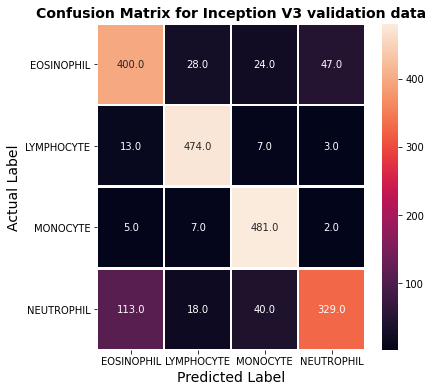

In [ ]:
# Plotting:

plt.subplots(figsize=(6,6))
sns.heatmap(confMatrix_inc_seg_cv,annot=True,fmt=".1f",linewidths=1.5)
plt.xlabel("Predicted Label", fontsize=label_size)
plt.ylabel("Actual Label", fontsize=label_size)
plt.xticks([0.5,1.5,2.5,3.5], ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'])
plt.yticks([0.5,1.5,2.5,3.5], ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], rotation=0)
plt.title('Confusion Matrix for Inception V3 with segmentation validation data', title_dict)
plt.show()

### VGG16 model with segmentation

**Loading the model:**

In [ ]:
vgg16_seg_model = VGG16(include_top = False, weights = 'imagenet',input_tensor = None, input_shape = (224,224,3), 
    pooling = None)

# Learning rate:
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

for layer in vgg16_seg_model.layers:
    layer.trainable = False 


**Coding and running the cross validation:**

In [ ]:
# Same as in InceptionV3, except for checkpoint- which currently was defined by learning rate:

n=train_seg_df.shape[0]

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

save_dir = '/content/drive/MyDrive/blood_cells_images/dataset2-master/saved_models/vgg_cv'

vgg_val_accuracy_list = []

train_datagen_seg = ImageDataGenerator()
val_datagen_seg = ImageDataGenerator()

                         
skf = StratifiedKFold(n_splits = 5, random_state = 6767, shuffle = True) 

i = 1
for train_index, val_index in skf.split(np.zeros(n),Y_seg):
  training_data = train_seg_df.iloc[train_index]
  validation_data = train_seg_df.iloc[val_index]
  
  trainGenerator = train_datagen_seg.flow_from_dataframe(training_data, directory=train_masked_folder,
						       x_col = "Img", y_col = "Label",
						       class_mode = "categorical", shuffle = True, target_size=(224, 224), seed=123)

  validationGenerator = val_datagen_seg.flow_from_dataframe(validation_data, directory=train_masked_folder,
						       x_col = "Img", y_col = "Label",
						       class_mode = "categorical", shuffle = False, target_size=(224, 224))
 
  
  input = Input(shape = (224,224,3))

  layer = vgg16_seg_model(inputs=input)
  layer = Flatten()(layer)
  layer = BatchNormalization()(layer)
  layer = Dense(units=256, activation='relu')(layer)
  layer = Dropout(0.7)(layer)
  layer = BatchNormalization()(layer)
  layer = Dense(units=128, activation='relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(units=64, activation='relu')(layer)
  layer = Dropout(0.3)(layer)
  layer = Dense(units=4,activation='softmax')(layer)

  model_seg_vgg16 = Model(inputs=input, outputs=layer)

  model_seg_vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
  vgg16_seg_hist_cv = model_seg_vgg16.fit_generator(
    trainGenerator,
    epochs = 30, 
    validation_data = validationGenerator, verbose=1, callbacks=learning_rate_reduction)
  with open("/content/drive/MyDrive/blood_cells_images/dataset2-master/vgg16_seg_hist_cv"+str(i)+".pkl", 'wb') as f:
     pickle.dump(vgg16_seg_hist_cv.history, f)

  pred = model_seg_vgg16.predict_generator(validationGenerator)
  pred = np.argmax(pred, axis=1)
  oos_y = validationGenerator.labels
  
  score = accuracy_score(y_pred=pred,y_true=oos_y)

  vgg_val_accuracy_list.append(score)

  if i == skf.n_splits:
    confMatrix_vgg_seg_cv = confusion_matrix(y_pred=pred,y_true=oos_y)
    with open("/content/drive/MyDrive/blood_cells_images/dataset2-master/confMatrix_vgg_seg_cv.pkl", 'wb') as f:
      pickle.dump(confMatrix_vgg_seg_cv, f)
  i+=1

with open("/content/drive/MyDrive/blood_cells_images/dataset2-master/vgg_cv_val_acc.pkl", 'wb') as f:
     pickle.dump(vgg_val_accuracy_list, f)

Found 7965 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
249/249 [==============================] - 29s 113ms/step - loss: 1.5832 - accuracy: 0.2956 - val_loss: 1.0824 - val_accuracy: 0.5552
Epoch 2/30
249/249 [==============================] - 27s 110ms/step - loss: 1.1914 - accuracy: 0.4617 - val_loss: 0.8452 - val_accuracy: 0.6401
Epoch 3/30
249/249 [==============================] - 27s 110ms/step - loss: 0.9946 - accuracy: 0.5435 - val_loss: 0.6631 - val_accuracy: 0.7319
Epoch 4/30
249/249 [==============================] - 28s 111ms/step - loss: 0.8391 - accuracy: 0.6265 - val_loss: 0.5704 - val_accuracy: 0.7445
Epoch 5/30
249/249 [==============================] - 27s 109ms/step - loss: 0.7484 - accuracy: 0.6570 - val_loss: 0.5126 - val_accuracy: 0.7937
Epoch 6/30
249/249 [==============================] - 28s 110ms/step - loss: 0.6641 - accuracy: 0.6956 - val_loss: 0.4884 - val_accuracy: 0.8012
Epoch 7/30
249/249 [==============================] - 27s 110ms/step - loss: 0.6077 - accuracy: 0.7237 - val_loss: 0.4521 - val_ac

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Found 7965 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
249/249 [==============================] - 28s 110ms/step - loss: 1.6510 - accuracy: 0.2648 - val_loss: 1.1640 - val_accuracy: 0.5321
Epoch 2/30
249/249 [==============================] - 27s 108ms/step - loss: 1.2461 - accuracy: 0.4125 - val_loss: 0.9094 - val_accuracy: 0.6024
Epoch 3/30
249/249 [==============================] - 27s 108ms/step - loss: 1.0257 - accuracy: 0.5238 - val_loss: 0.7172 - val_accuracy: 0.6903
Epoch 4/30
249/249 [==============================] - 27s 109ms/step - loss: 0.8820 - accuracy: 0.5925 - val_loss: 0.6326 - val_accuracy: 0.7259
Epoch 5/30
249/249 [==============================] - 27s 106ms/step - loss: 0.7722 - accuracy: 0.6373 - val_loss: 0.5418 - val_accuracy: 0.7510
Epoch 6/30
249/249 [==============================] - 27s 108ms/step - loss: 0.7049 - accuracy: 0.6782 - val_loss: 0.5446 - val_accuracy: 0.7791
Epoch 7/30
249/249 [==============================] - 27s 107ms/step - loss: 0.6513 - accuracy: 0.6988 - val_loss: 0.4979 - val_ac

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Found 7966 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
249/249 [==============================] - 29s 113ms/step - loss: 1.6250 - accuracy: 0.2774 - val_loss: 1.1243 - val_accuracy: 0.5434
Epoch 2/30
249/249 [==============================] - 27s 107ms/step - loss: 1.2329 - accuracy: 0.4405 - val_loss: 0.8814 - val_accuracy: 0.6344
Epoch 3/30
249/249 [==============================] - 26s 106ms/step - loss: 1.0310 - accuracy: 0.5377 - val_loss: 0.7032 - val_accuracy: 0.7107
Epoch 4/30
249/249 [==============================] - 27s 107ms/step - loss: 0.8944 - accuracy: 0.5948 - val_loss: 0.6013 - val_accuracy: 0.7097
Epoch 5/30
249/249 [==============================] - 27s 108ms/step - loss: 0.7775 - accuracy: 0.6464 - val_loss: 0.5608 - val_accuracy: 0.7474
Epoch 6/30
249/249 [==============================] - 27s 107ms/step - loss: 0.7026 - accuracy: 0.6809 - val_loss: 0.5180 - val_accuracy: 0.7433
Epoch 7/30
249/249 [==============================] - 27s 107ms/step - loss: 0.6482 - accuracy: 0.7072 - val_loss: 0.4736 - val_ac

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Found 7966 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
249/249 [==============================] - 29s 112ms/step - loss: 1.5777 - accuracy: 0.3122 - val_loss: 1.0578 - val_accuracy: 0.5455
Epoch 2/30
249/249 [==============================] - 27s 108ms/step - loss: 1.1829 - accuracy: 0.4492 - val_loss: 0.8542 - val_accuracy: 0.6514
Epoch 3/30
249/249 [==============================] - 27s 109ms/step - loss: 1.0203 - accuracy: 0.5331 - val_loss: 0.6846 - val_accuracy: 0.6811
Epoch 4/30
249/249 [==============================] - 27s 110ms/step - loss: 0.8747 - accuracy: 0.6012 - val_loss: 0.5845 - val_accuracy: 0.7067
Epoch 5/30
249/249 [==============================] - 27s 109ms/step - loss: 0.7510 - accuracy: 0.6559 - val_loss: 0.5394 - val_accuracy: 0.7569
Epoch 6/30
249/249 [==============================] - 27s 109ms/step - loss: 0.6743 - accuracy: 0.6749 - val_loss: 0.5228 - val_accuracy: 0.7659
Epoch 7/30
249/249 [==============================] - 27s 109ms/step - loss: 0.6872 - accuracy: 0.6913 - val_loss: 0.4978 - val_ac

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Found 7966 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
249/249 [==============================] - 28s 108ms/step - loss: 1.6825 - accuracy: 0.2996 - val_loss: 1.1104 - val_accuracy: 0.5143
Epoch 2/30
249/249 [==============================] - 27s 108ms/step - loss: 1.1954 - accuracy: 0.4506 - val_loss: 0.9072 - val_accuracy: 0.5741
Epoch 3/30
249/249 [==============================] - 27s 108ms/step - loss: 1.0260 - accuracy: 0.5193 - val_loss: 0.7515 - val_accuracy: 0.6730
Epoch 4/30
249/249 [==============================] - 27s 107ms/step - loss: 0.8662 - accuracy: 0.6111 - val_loss: 0.6388 - val_accuracy: 0.7077
Epoch 5/30
249/249 [==============================] - 27s 110ms/step - loss: 0.7622 - accuracy: 0.6525 - val_loss: 0.5705 - val_accuracy: 0.7157
Epoch 6/30
249/249 [==============================] - 27s 107ms/step - loss: 0.7007 - accuracy: 0.6751 - val_loss: 0.5219 - val_accuracy: 0.7514
Epoch 7/30
249/249 [==============================] - 27s 109ms/step - loss: 0.6687 - accuracy: 0.6901 - val_loss: 0.4895 - val_ac

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


**Validation accuracy:**

In [ ]:
# Loading:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/vgg_cv_val_acc.pkl', 'rb') as f:
    vgg_cv_val_acc = pickle.load(f)

In [ ]:
# Display valdiation accuracy results:
vgg_cv_val_acc

[0.9041164658634538,
 0.9021084337349398,
 0.8900050226017077,
 0.9005524861878453,
 0.8965344048216977]

**Confusion matrix:**

In [ ]:
# Loading confusion matrix:
with open('/content/drive/MyDrive/blood_cells_images/dataset2-master/confMatrix_vgg_seg_cv.pkl', 'rb') as f:
    confMatrix_vgg_seg_cv = pickle.load(f)

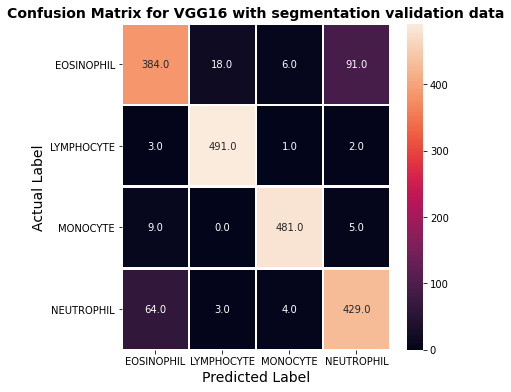

In [ ]:
# Plotting:
plt.subplots(figsize=(6,6))
sns.heatmap(confMatrix_vgg_seg_cv,annot=True,fmt=".1f",linewidths=1.5)
plt.xlabel("Predicted Label", fontsize=label_size)
plt.ylabel("Actual Label", fontsize=label_size)
plt.xticks([0.5,1.5,2.5,3.5], ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'])
plt.yticks([0.5,1.5,2.5,3.5], ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], rotation=0)
plt.title('Confusion Matrix for VGG16 with segmentation validation data', title_dict)
plt.show()

In [ ]:
k_fold =5

In [ ]:
list(range(1, k_fold+1))

[1, 2, 3, 4, 5]

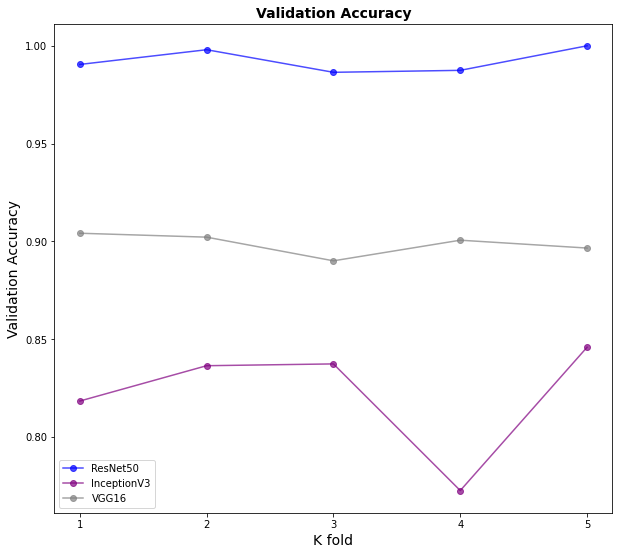

In [ ]:
n_fold =5

k_fold = list(range(1, n_fold+1)) 
fig , ax = plt.subplots()

fig.set_size_inches(10,9)
    
ax.plot(k_fold , rn_cv_val_acc , 'o-' , label = 'ResNet50', color= 'blue', alpha=0.7)
ax.plot(k_fold , inc_cv_val_acc , 'o-' , label = 'InceptionV3', color= 'purple', alpha=0.7)
ax.plot(k_fold , vgg_cv_val_acc , 'o-' , label = 'VGG16', color= 'gray', alpha=0.7)
ax.set_title('Validation Accuracy',title_dict)
ax.legend()
ax.set_xticks(list(range(1, n_fold+1)))
ax.set_xlabel("K fold", fontsize=label_size)
ax.set_ylabel("Validation Accuracy",fontsize=label_size)
plt.show()

## **Conclusions:**

- Using cross validation we show the validity of all three models.
- All three models seem to have relatively high validation accuracy scores.
- ResNet50 has the best results (in accordance with previous findings).

# **THANK YOU :)**